<a href="https://colab.research.google.com/github/revin357/Car_classifier/blob/master/car_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -U tensorflow_hub
!pip install tf-nightly-gpu
!pip install pylint

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.4.0)


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from __future__ import absolute_import, division, print_function

import matplotlib.pylab as plt
import tensorflow as tf
tf.enable_eager_execution()


In [0]:
import tensorflow_hub as hub
from tensorflow.keras import layers
from keras.callbacks import *



In [0]:
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"

In [0]:
IMAGE_SHAPE = (224,224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

In [0]:
import os
import numpy as np
import PIL.Image as Image

data_root = '../content/gdrive/My Drive/Software Engineering Practice/train'

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 8144 images belonging to 196 classes.


In [0]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 196)


In [0]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [0]:
labels_path = '../content/gdrive/My Drive/Software Engineering Practice/training_names.txt'
imagenet_labels = np.array(open(labels_path).read().splitlines())
predicted_class_names = imagenet_labels[np.argmax(label_batch, axis=-1)]
predicted_class_names

array(['Hyundai Santa Fe SUV 2012', 'Dodge Magnum Wagon 2008',
       'Audi A5 Coupe 2012', 'Mercedes-Benz 300-Class Convertible 1993',
       'Dodge Ram Pickup 3500 Quad Cab 2009', 'FIAT 500 Abarth 2012',
       'Chevrolet Traverse SUV 2012', 'Audi S4 Sedan 2007',
       'Land Rover Range Rover SUV 2012', 'Jeep Compass SUV 2012',
       'BMW X3 SUV 2012', 'Jeep Compass SUV 2012',
       'Nissan Leaf Hatchback 2012', 'Acura ZDX Hatchback 2012',
       'Audi S4 Sedan 2007', 'Chevrolet TrailBlazer SS 2009',
       'Rolls-Royce Phantom Sedan 2012', 'BMW 3 Series Sedan 2012',
       'Acura TL Type-S 2008', 'Acura TSX Sedan 2012',
       'Audi 100 Wagon 1994', 'Daewoo Nubira Wagon 2002',
       'Suzuki SX4 Hatchback 2012', 'Dodge Dakota Crew Cab 2010',
       'Chrysler PT Cruiser Convertible 2008',
       'Bentley Arnage Sedan 2009',
       'Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
       'Jeep Grand Cherokee SUV 2012', 'Chevrolet Express Cargo Van 2007',
       'Lamborghini Reventon

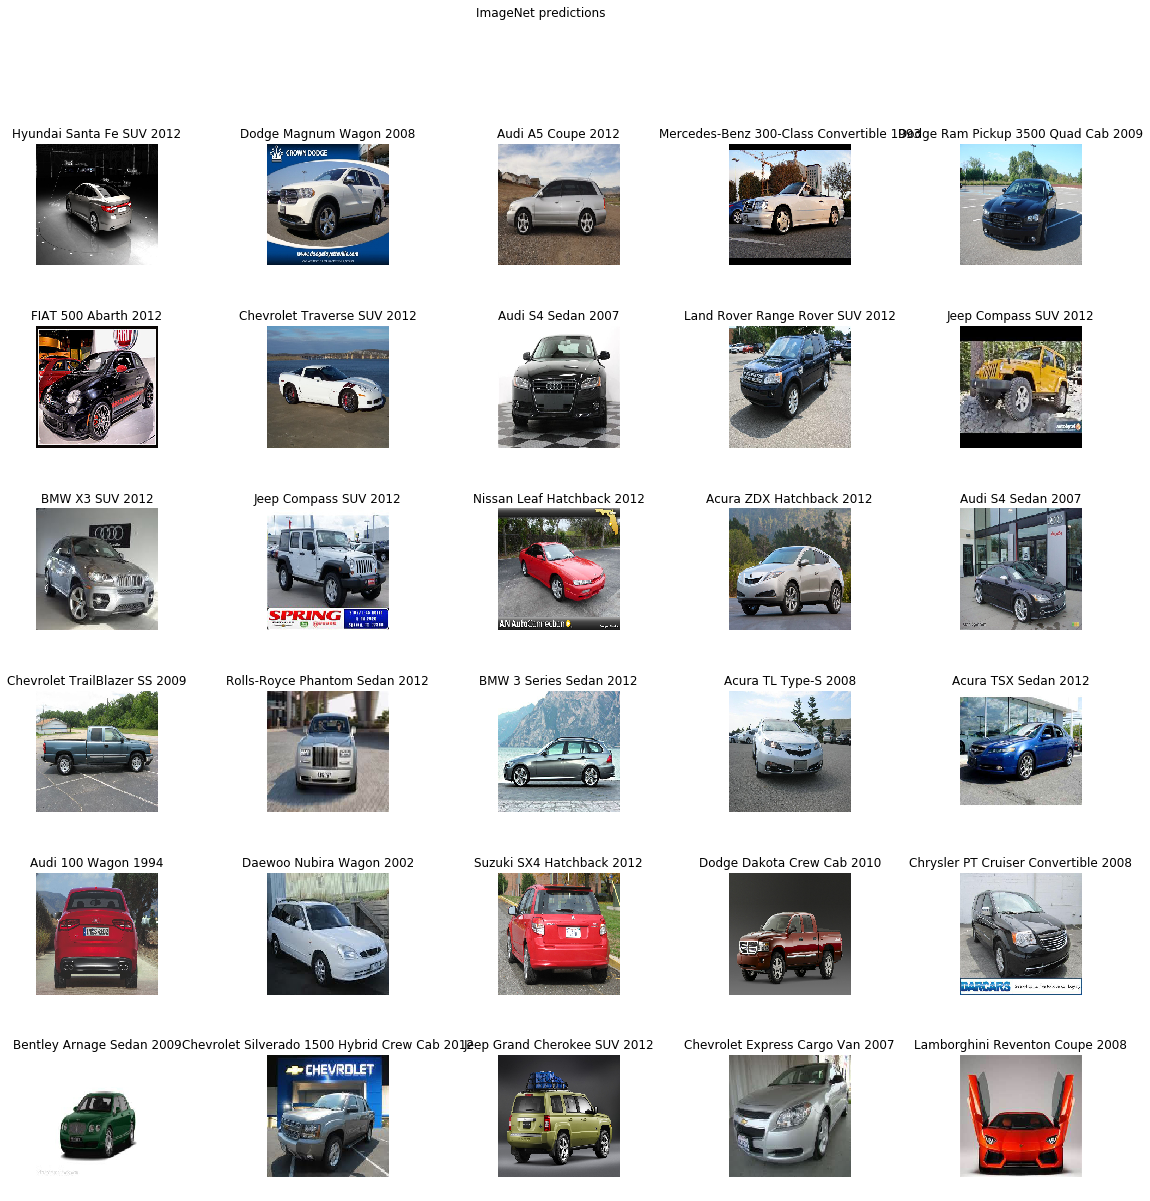

In [0]:
plt.figure(figsize=(20,19))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
  _= plt.suptitle("ImageNet predictions")

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224,224,3))

In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [0]:
model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 196)               251076    
Total params: 2,509,060
Trainable params: 251,076
Non-trainable params: 2,257,984
_________________________________________________________________


In [0]:
predictions = model(image_batch)

predictions.shape

TensorShape([Dimension(32), Dimension(196)])

In [0]:
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
    metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [0]:
from keras.callbacks import *
from tensorflow.keras.callbacks import *

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

import os 
checkpoint_path = "training_1/cp.ckpt" 

checkpoint_dir = os.path.dirname(checkpoint_path)

 # Create checkpoint  callback 
cp_callback =ModelCheckpoint(checkpoint_path, 
     monitor='acc',save_best_only=True,save_weights_only=True,verbose=1)

history = model.fit(image_data, epochs=50,
                   steps_per_epoch=steps_per_epoch,
                   callbacks = [cp_callback])

Epoch 1/50
254/255 [============================>.] - ETA: 3s - loss: 4.7195 - acc: 0.0942
Epoch 00001: acc improved from -inf to 0.09430, saving model to training_1/cp.ckpt
255/255 [==============================] - 883s 3s/step - loss: 4.7167 - acc: 0.0943
Epoch 2/50
254/255 [============================>.] - ETA: 3s - loss: 2.9437 - acc: 0.3786
Epoch 00002: acc improved from 0.09430 to 0.37868, saving model to training_1/cp.ckpt
255/255 [==============================] - 874s 3s/step - loss: 2.9435 - acc: 0.3787
Epoch 3/50
254/255 [============================>.] - ETA: 3s - loss: 2.1908 - acc: 0.5443
Epoch 00003: acc improved from 0.37868 to 0.54433, saving model to training_1/cp.ckpt
255/255 [==============================] - 870s 3s/step - loss: 2.1897 - acc: 0.5443
Epoch 4/50
254/255 [============================>.] - ETA: 3s - loss: 1.7041 - acc: 0.6583
Epoch 00004: acc improved from 0.54433 to 0.65815, saving model to training_1/cp.ckpt
255/255 [==============================]

KeyboardInterrupt: ignored

In [0]:
model.save('my_model.h5')

RuntimeError: ignored

In [0]:
import os 
checkpoint_path = "training_1\cp.ckpt" 

checkpoint_dir = os.path.dirname(checkpoint_path)
model.load_weights(checkpoint_path)


E0510 12:35:49.723467 140251998087040 ultratb.py:982] An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



NotFoundError: ignored

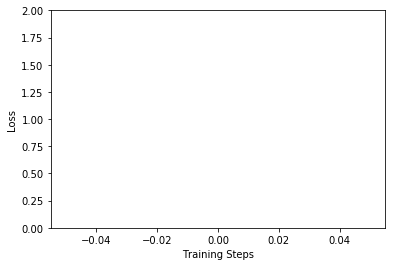

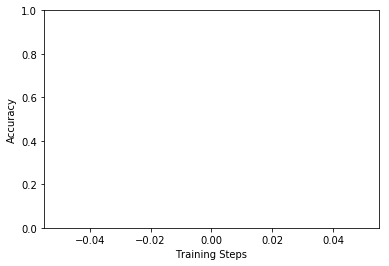

In [0]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [0]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['Am General Hummer Suv 2000', 'Acura Integra Type R 2001',
       'Acura Rl Sedan 2012', 'Acura Tl Sedan 2012',
       'Acura Tl Type-S 2008', 'Acura Tsx Sedan 2012',
       'Acura Zdx Hatchback 2012',
       'Aston Martin V8 Vantage Convertible 2012',
       'Aston Martin V8 Vantage Coupe 2012',
       'Aston Martin Virage Convertible 2012',
       'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994',
       'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012',
       'Audi Rs 4 Convertible 2008', 'Audi S4 Sedan 2007',
       'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012',
       'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011',
       'Audi Tt Hatchback 2011', 'Audi Tt Rs Coupe 2012',
       'Audi Tts Coupe 2012', 'Audi V8 Sedan 1994',
       'Bmw 1 Series Convertible 2012', 'Bmw 1 Series Coupe 2012',
       'Bmw 3 Series Sedan 2012', 'Bmw 3 Series Wagon 2012',
       'Bmw 6 Series Convertible 2007', 'Bmw Activehybrid 5 Sedan 2012',
       'Bmw M3 Coupe 2012', 'Bmw

In [0]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]
labels_batch

array(['Hyundai Azera Sedan 2012', 'Dodge Durango Suv 2012',
       'Audi 100 Wagon 1994', 'Mercedes-Benz 300-Class Convertible 1993',
       'Dodge Charger Srt-8 2009', 'Fiat 500 Abarth 2012',
       'Chevrolet Corvette Ron Fellows Edition Z06 2007',
       'Audi Tts Coupe 2012', 'Land Rover Lr2 Suv 2012',
       'Jeep Wrangler Suv 2012', 'Bmw X6 Suv 2012',
       'Jeep Wrangler Suv 2012', 'Nissan 240Sx Coupe 1998',
       'Acura Zdx Hatchback 2012', 'Audi Tts Coupe 2012',
       'Chevrolet Silverado 1500 Extended Cab 2012',
       'Rolls-Royce Phantom Sedan 2012', 'Bmw 3 Series Wagon 2012',
       'Acura Tl Sedan 2012', 'Acura Tl Type-S 2008',
       'Audi S4 Sedan 2012', 'Daewoo Nubira Wagon 2002',
       'Suzuki Sx4 Hatchback 2012', 'Dodge Dakota Crew Cab 2010',
       'Chrysler Town And Country Minivan 2012',
       'Bentley Continental Flying Spur Sedan 2007',
       'Chevrolet Avalanche Crew Cab 2012', 'Jeep Patriot Suv 2012',
       'Chevrolet Malibu Hybrid Sedan 2010',
       

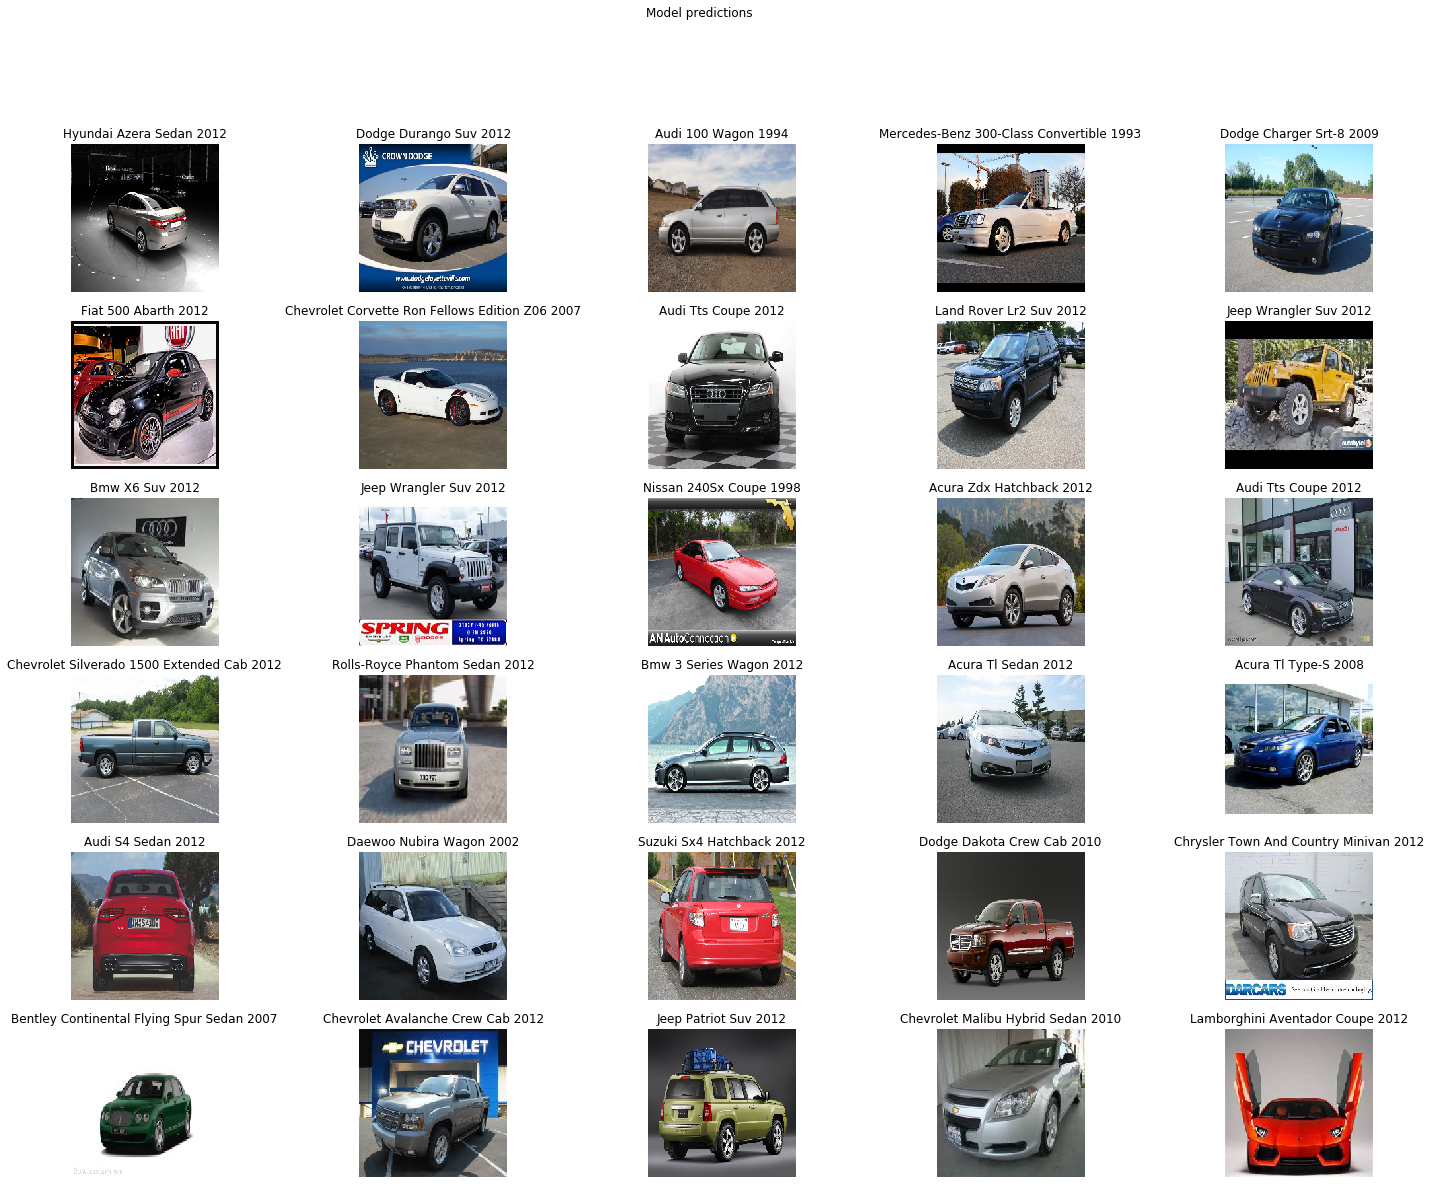

In [0]:
plt.figure(figsize=(25,19))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

In [0]:
export_path = tf.contrib.saved_model.save_keras_model(model, "./saved_models")
export_path

W0510 16:08:17.327022 140718749562752 lazy_loader.py:50] 
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0510 16:08:19.613083 140718749562752 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/saved_model/load.py:266: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0510 16:08:22.910071 140718749562752 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed 